# Installations

In [1]:
!pip install fiftyone
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!python -m pip install pyyaml==5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 32.9 MB/s 
     |████████████████████████████████| 63 kB 972 kB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 132 kB 75.3 MB/s 
     |████████████████████████████████| 564 kB 54.8 MB/s 
     |████████████████████████████████| 192 kB 64.8 MB/s 
     |████████████████████████████████| 226 kB 27.4 MB/s 
     |████████████████████████████████| 37.8 MB 1.1 MB/s 
     |████████████████████████████████| 133 kB 81.0 MB/s 
     |████████████████████████████████| 108 kB 68.1 MB/s 
     |████████████████████████████████| 79.9 MB 154 kB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 57 kB 7.4 MB/s 
     |████████████████████████████████| 80 kB 10.4 MB/s 
     |████████████████████████████████| 202 kB 80.5 MB/s 
     |████████████████████████████████| 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 33.2 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=3e146195ce2bedd8e9862b269c3b162ab8db79392805b5a47a8d89ee5b12a3d2
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.


# Imports

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
import cv2
import torch

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from PIL import Image


Migrating database to v0.18.0


INFO:fiftyone.migrations.runner:Migrating database to v0.18.0


In [3]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.13 ; cuda:  cu116
detectron2: 0.6


# Load the dataset

In [4]:
dataset_name="quickstart-geo"
dataset = foz.load_zoo_dataset(dataset_name)

INFO:fiftyone.zoo.datasets:Downloading dataset to '/root/fiftyone/quickstart-geo'


INFO:fiftyone.zoo.datasets.base:Downloading dataset...


 100% |████|  223.5Mb/223.5Mb [647.6ms elapsed, 0s remaining, 345.1Mb/s]      


INFO:eta.core.utils: 100% |████|  223.5Mb/223.5Mb [647.6ms elapsed, 0s remaining, 345.1Mb/s]      


Extracting dataset...


INFO:fiftyone.zoo.datasets.base:Extracting dataset...


Parsing dataset metadata


INFO:fiftyone.zoo.datasets.base:Parsing dataset metadata


Found 500 samples


INFO:fiftyone.zoo.datasets.base:Found 500 samples


Dataset info written to '/root/fiftyone/quickstart-geo/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/quickstart-geo/info.json'


Loading 'quickstart-geo'


INFO:fiftyone.zoo.datasets:Loading 'quickstart-geo'


 100% |█████████████████| 500/500 [15.4s elapsed, 0s remaining, 20.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 500/500 [15.4s elapsed, 0s remaining, 20.6 samples/s]      


Dataset 'quickstart-geo' created


INFO:fiftyone.zoo.datasets:Dataset 'quickstart-geo' created


# Helper functions

In [5]:
def get_cropped_image(image,lowest_sky_pixel):
    """
    a function that gets an image and it's lowest sky pixel and returns a cropped image
    with a fixed height and width
    Input:
    image- the image we want to crop
    lowest_sky_pixel- the lowest sky pixel height
    Output:
    crop_img- the new and cropped image
    """
    height,width,_ = image.shape
    crop_img = image[height-lowest_sky_pixel-1:height, 0:width]
    return crop_img

def panoptic_segmentation(image):
  """
  a function that does panoptic segmentation on an image
  Input:
  image- the image we want to do panoptic segmentation on.
  Output:
  predictions- a tensor of shape (H, W), containing the segment id of each pixel.
  segmentInfo- list of dicts. each dict describes one segment id in predictions.
  """
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")

  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6


  predictor = DefaultPredictor(cfg)
  predictions, segmentInfo = predictor(image)['panoptic_seg']
  return predictions, segmentInfo

def instance_segmentation(image):
  """
  a function that does instance segmentation on an image and returns the image after this segmentation.
  Input:
  image- the image we want to do instance segmentation on.
  Output:
  segmented_image- the image after the segmentation
  """
  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
  predictor = DefaultPredictor(cfg)
  outputs = predictor(image)
  viz = Visualizer(image[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0])) #images are loaded by opencv in BGR format and hence need to be converted to RGB
  output = viz.draw_instance_predictions(outputs["instances"].to("cpu"))
  segmented_image=output.get_image()[:,:,::-1]
  return segmented_image

def get_lowest_sky_pixel(predictions,segmentations):
  """
  a function that find the height of the lowest sky pixel in an image.
  Input:
  predictions- a tensor of shape (H, W) we got from the panoptic segmentation, containing the segment id of each pixel. 
  segmentations- a list of ids of all the sky objects in an image.
  Output:
  lowest_pixel- the height of the lowest sky pixel in an image
  """
  pixels=predictions.tolist()
  lowest_pixel=0
  flag=False
  for i,s in enumerate(reversed(pixels)):
    for j in segmentations:
      if j in s:
        lowest_pixel=i
        flag=True
        break
    if flag==True:
      break
  return lowest_pixel

def get_sky_segmentation_id(segmentInfo):
  """
  a function that returns the id's of all the sky objects on an image.
  Input: 
  segmentInfo- list of dicts. each dict describes one segment id on an image.
  Output:
  segmentations- a list of all sky segment ids.
  """
  sky_category_id=40 # category of sky object
  segmentations=[item['id'] for item in segmentInfo if item['category_id'] == sky_category_id]
  return segmentations


def get_img_info(image_path):
  """
  a function that finds an image information and annotations in a json file 
  Input:
  image_path- the key of the image path in the json file
  Output:
  item- the infomation and annotations about the image
  """
  json_path=os.path.join("/root/fiftyone",dataset_name,"samples.json")
  f = open(json_path)
  json_file=json.load(f)['samples']
  
  item = next((item for item in json_file if item['filepath'] == image_path), None)
  return item

def save_json(json_data,json_file):
  """
  a function that saves the information and annotations of all the images in a json file
  Input:
  json_data- a list of dicts where each dict saves the meatadata of an image
  """
  with open(json_file, 'w') as outfile:
    json.dump(json_data, outfile)

def get_images_from_json(json_path):
  """
  a function that gets the path of the json file and returns the path of each image
  Input: 
  json_path- the path of a json file
  Output:
  imgs_paths- a list of every image path as saved in the json file
  """
  f = open(json_path)
  imgs_json=json.load(f)
  imgs_paths=[]
  for i in imgs_json:
    imgs_paths.append(i['filepath'])
  return imgs_paths

def print_images(images):
  """
  a function that prints the new segmented and cropped images
  Input: 
  images- a list that saves the path of each image
  """
  for i in images:
    img=cv2.imread(i)
    cv2_imshow(img)
    print("\n")


# Main run

In [6]:

json_data=[]
images_path=os.path.join("/root/fiftyone",dataset_name,"data")
if os.path.exists('data')==False:
  os.mkdir('data')

for i in os.listdir(images_path)[:20]:
  #read the image
  image_path=os.path.join(images_path,i)
  image=cv2.imread(image_path)

  # apply panoptic segmentation on the image
  predictions, segmentInfo=panoptic_segmentation(image)

  # find the segment id's of all the sky objects in the image
  segmentations=get_sky_segmentation_id(segmentInfo)

  # find the lowest pixel of sky in the image
  lowest_sky_pixel=get_lowest_sky_pixel(predictions,segmentations)
  
  # crop the image
  cropped_img=get_cropped_image(image,lowest_sky_pixel)

  # save the new cropped image
  image_identifier=os.path.join('data',i)
  cv2.imwrite(image_identifier,instance_segmentation(cropped_img))

  # get the data about the image to save it in a json file
  info=get_img_info(image_identifier)
  json_data.append(info)

# save all the images data and annotations in a new json file
json_file='samples.json'
save_json(json_data,json_file)



[12/25 11:38:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


model_final_cafdb1.pkl: 261MB [00:34, 7.58MB/s]                           
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/25 11:38:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:17, 10.2MB/s]                           


[12/25 11:39:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...
[12/25 11:39:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
[12/25 11:39:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...
[12/25 11:39:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
[12/25 11:39:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/

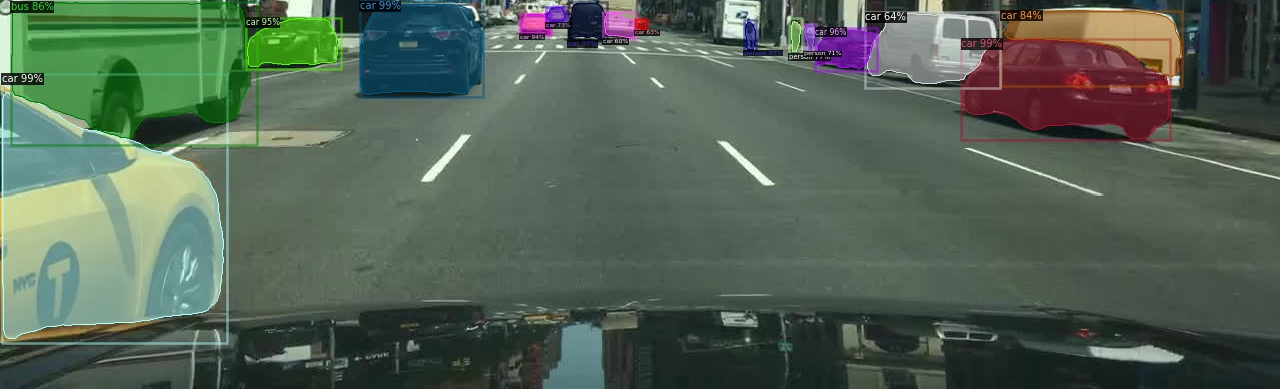

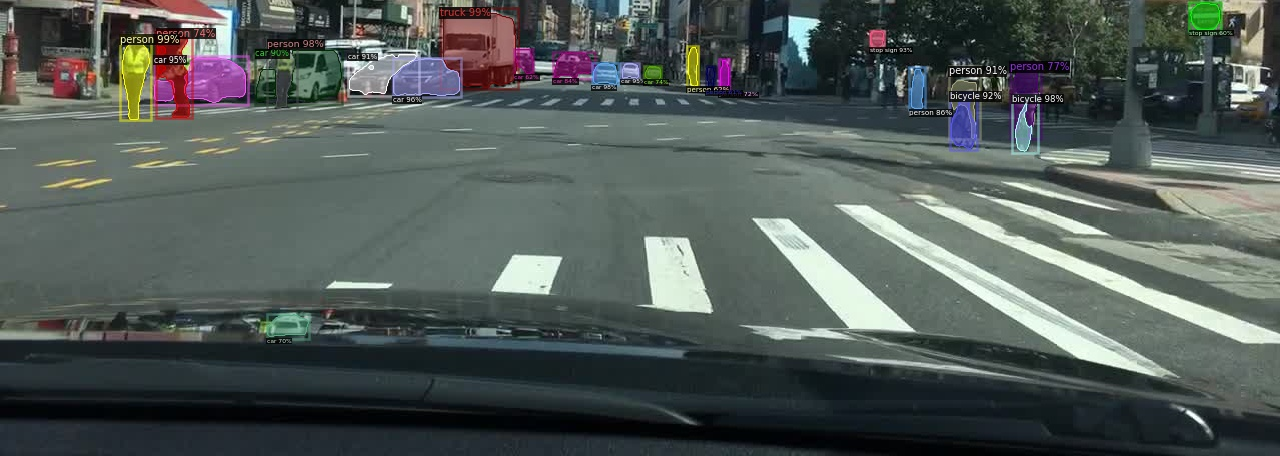

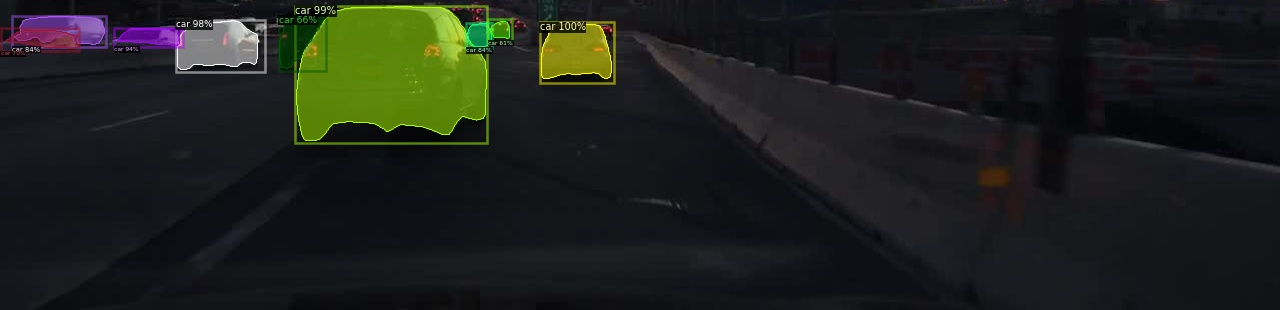

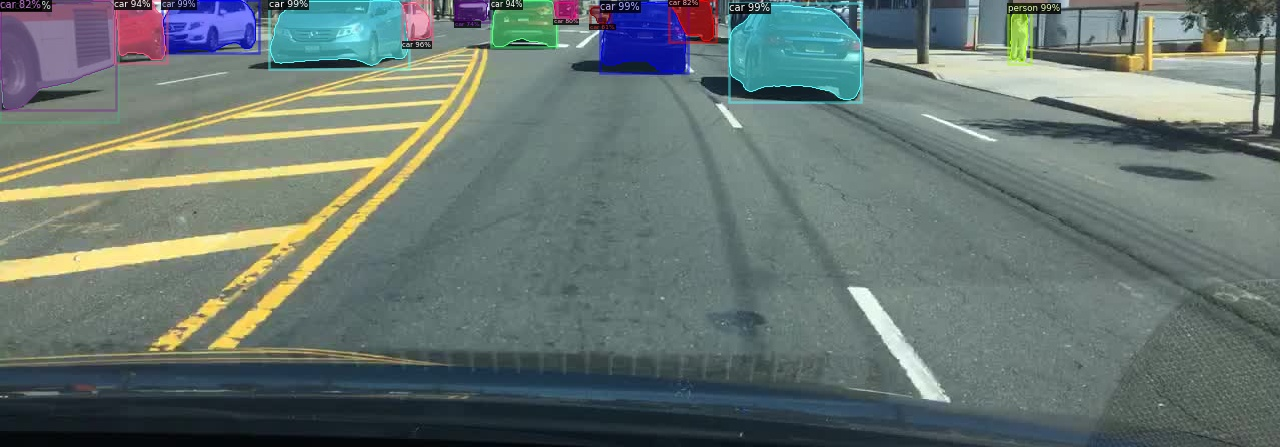

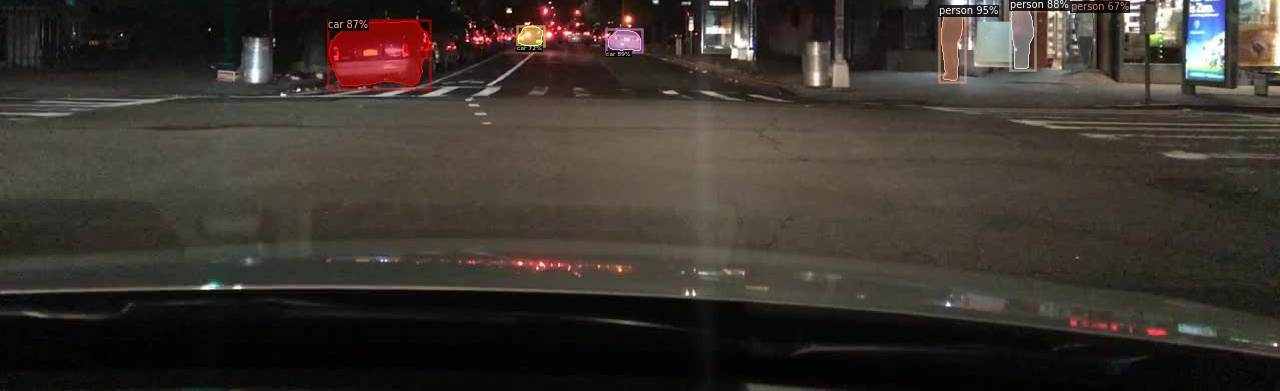

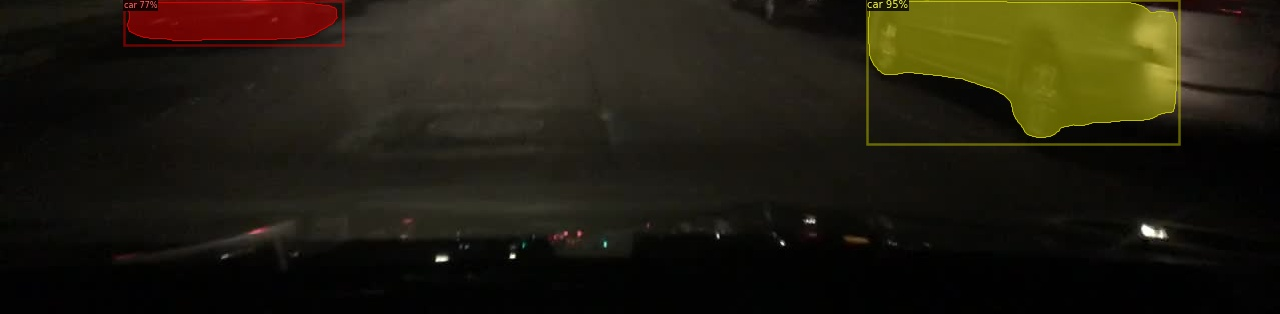

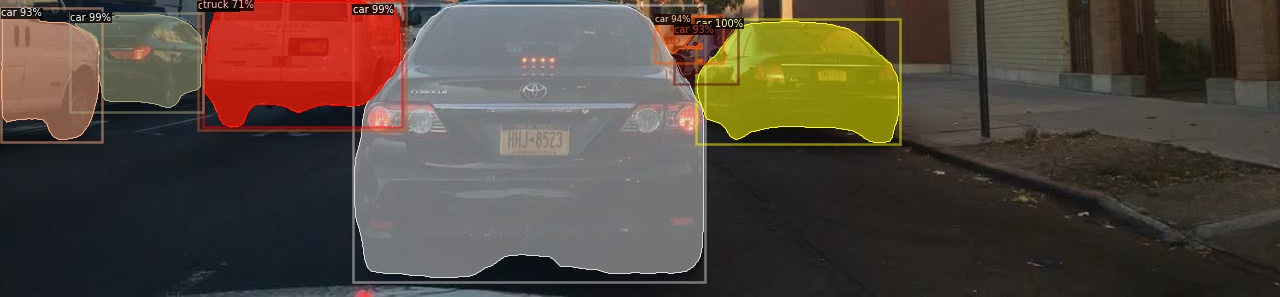

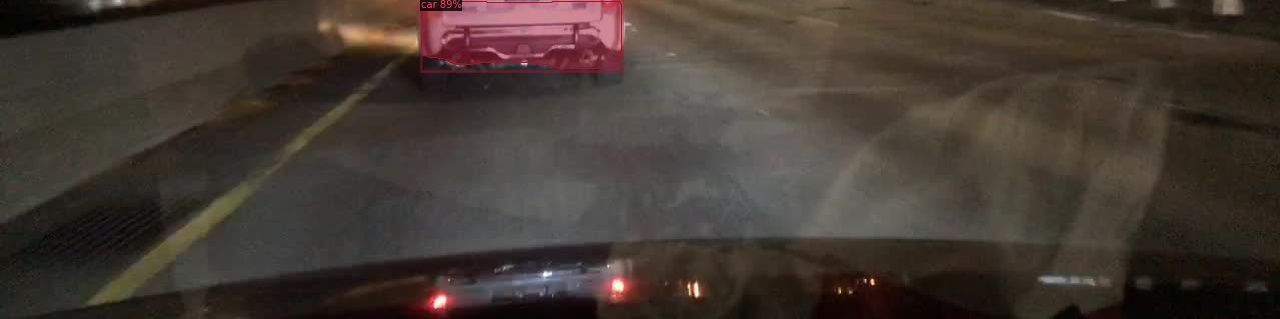

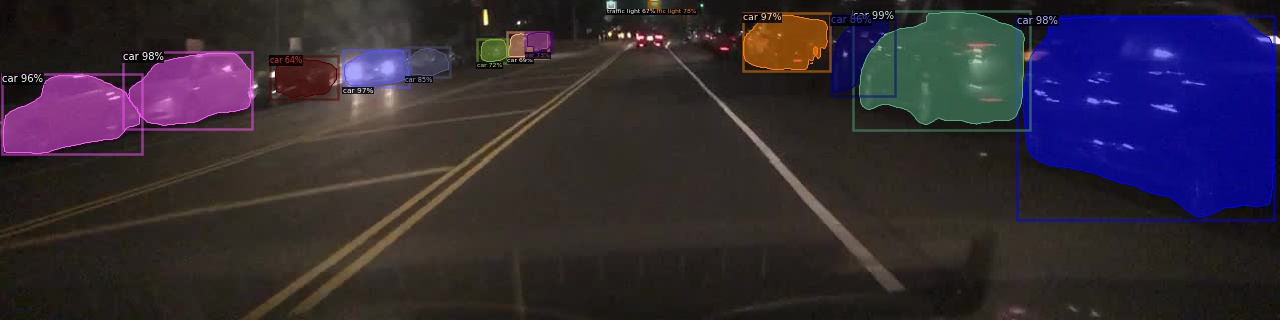

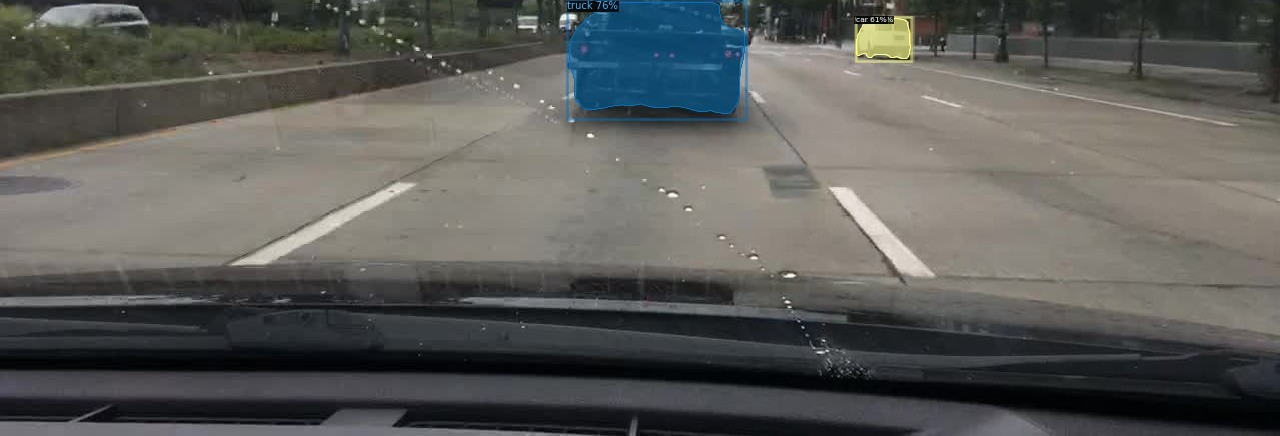

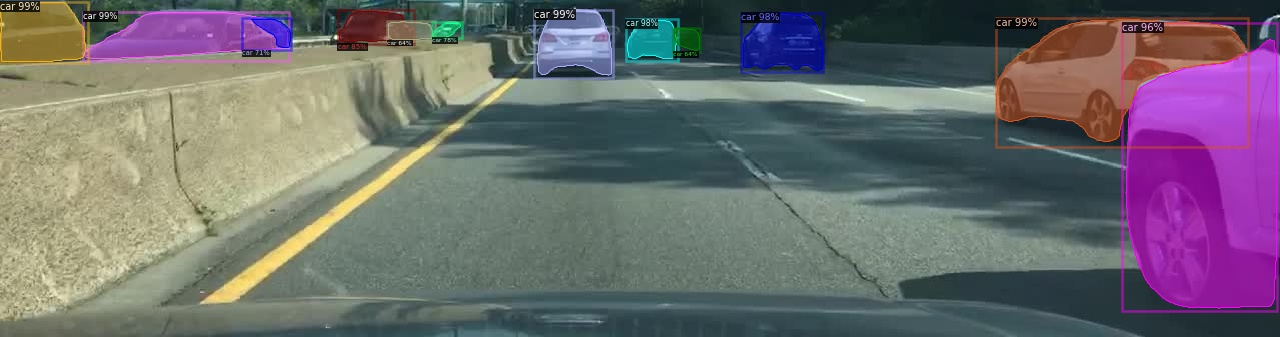

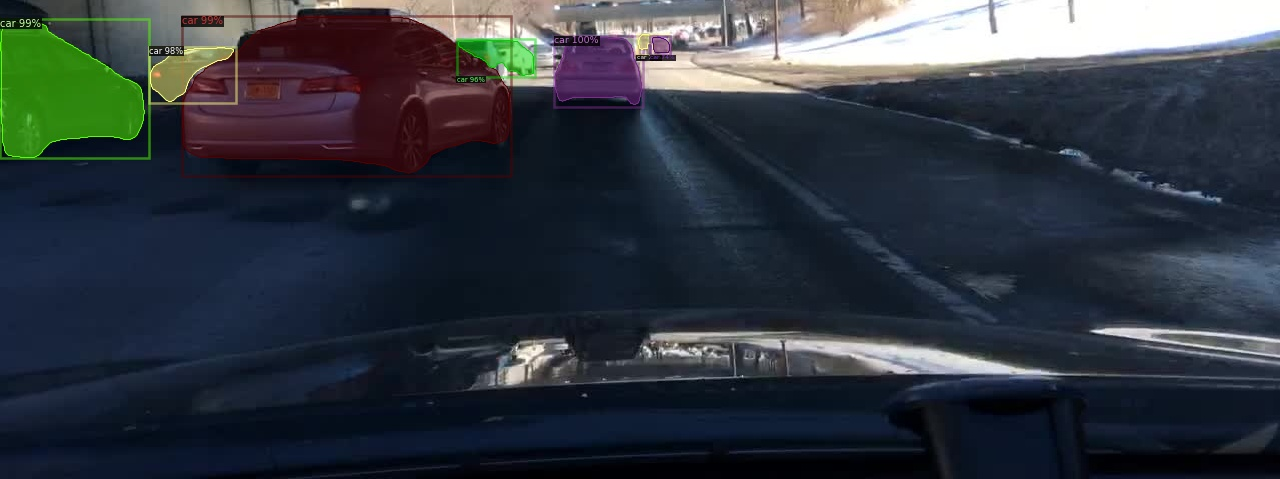

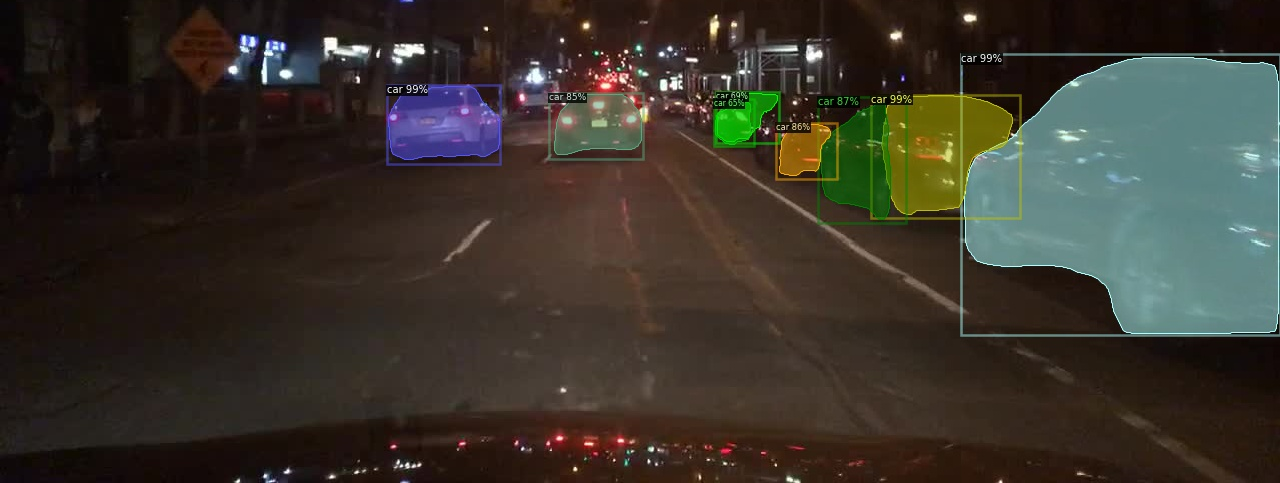

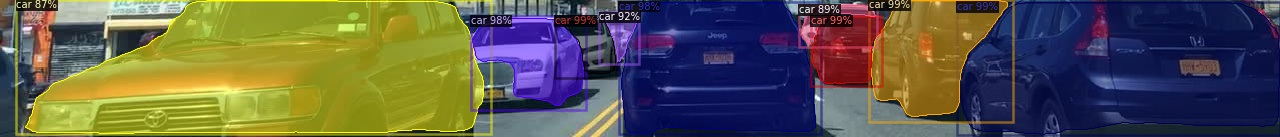

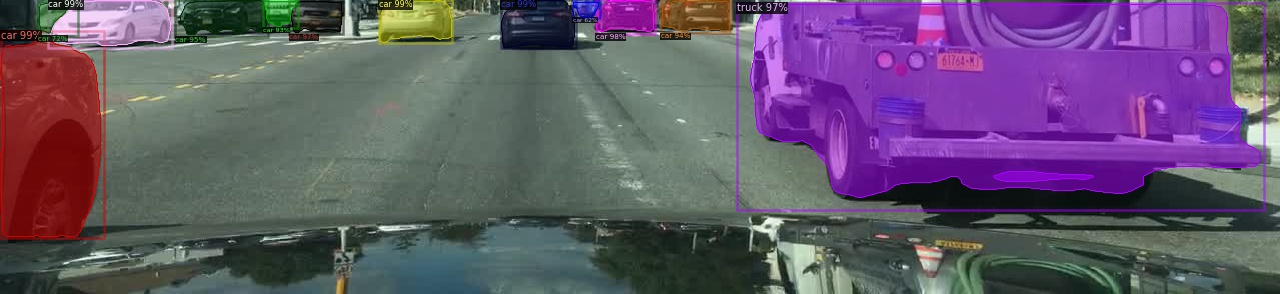

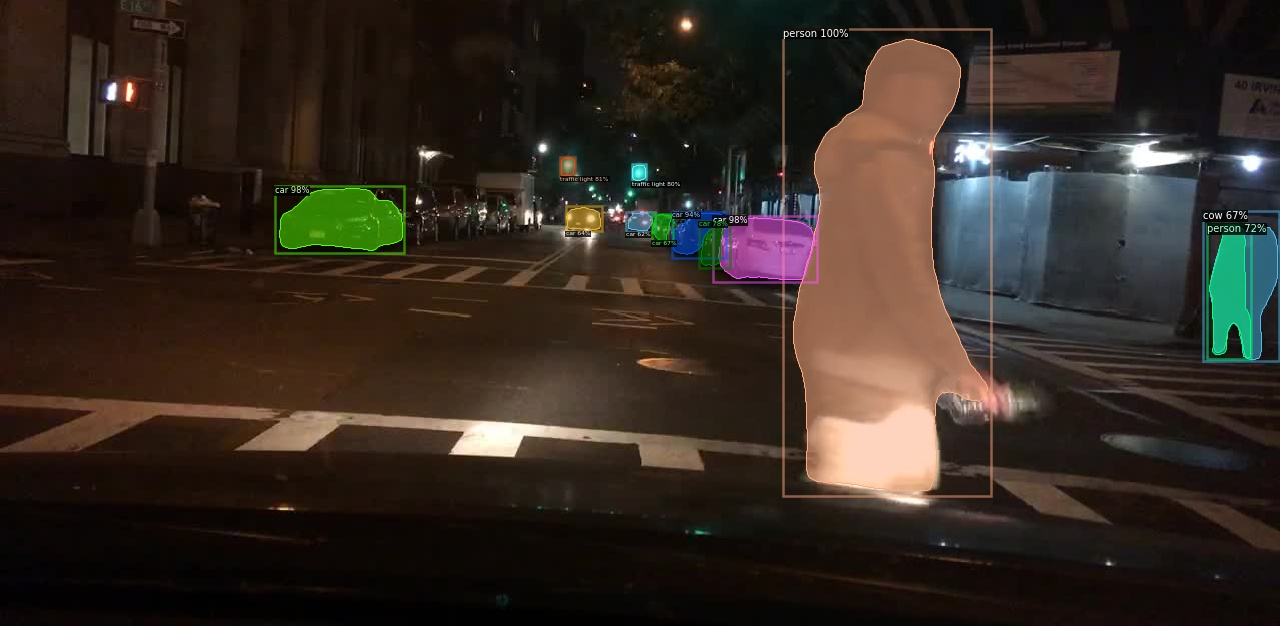

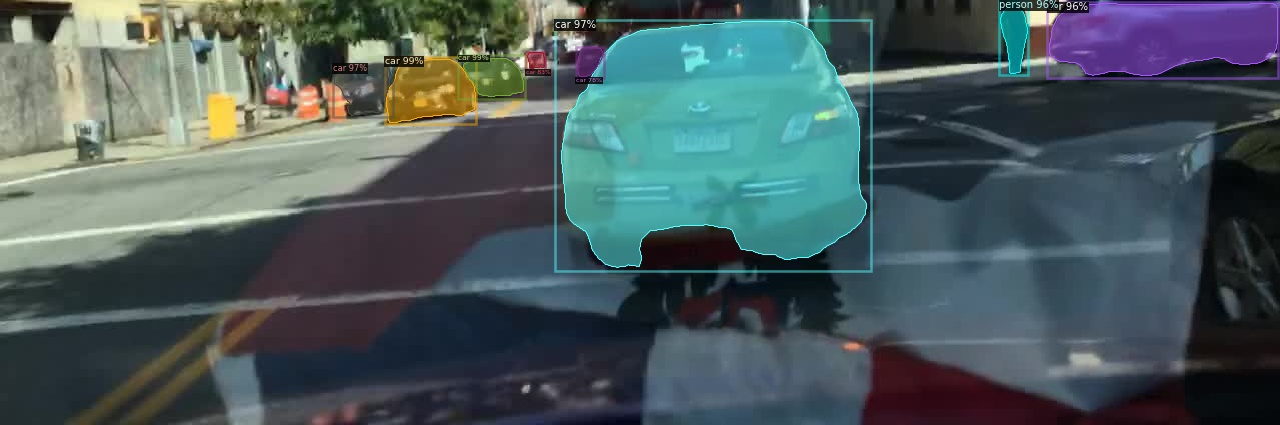

In [7]:
# get all the paths of the images from the json file
paths=get_images_from_json(json_file)

# print all the segmented images
print_images(paths)